## 1. Set path to a data file

In [1]:
import os, sys

# Add the project root to sys.path so I can import submodules
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import src.active_learning.acquisition as aq
import src.active_learning.gaussian_process as gpc
import src.visualization.plot as pl

# Define the home directory and path to data
# Target metric: initial CO2 conversion
path = "./20250228_sheet_for_ML_unique.xlsx"

/Users/djayshin/miniconda3/envs/botorch_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Preprocess data and train a Gaussian process model 
* `path`: path to data file (excel)

In [2]:
# Train the Gaussian Process model
GP = gpc.GaussianProcess()
GP.preprocess_data_at_once(path=path,
                           target='CO2 Conversion (%)_initial value',
                           x_range_min=[300, 0.1, 0.005, 0], x_range_max=[550, 1.0, 0.02, 1])
GP.train_gp()

self.df.dtypes: reaction_temp                         int64
Rh_weight_loading                   float64
Rh_total_mass                       float64
synth_method                          int64
CO2 Conversion (%)_initial value    float64
dtype: object
numerical_features (selected):  ['reaction_temp', 'Rh_weight_loading', 'Rh_total_mass', 'synth_method']
categorical_features (selected):  []


/Users/djayshin/Dropbox/0.Dongjae/04.SUNCAT@SLAC,Standford(2402~)/231128_research/240602_ML_codes/CatDegUS/src/active_learning/gaussian_process.py:92: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.df.replace(
/Users/djayshin/miniconda3/envs/botorch_env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
/Users/djayshin/miniconda3/envs/botorch_env/lib/python3.12/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


SingleTaskGP(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): MaternKernel(
      (lengthscale_prior): GammaPrior()
      (raw_lengthscale_constraint): Positive()
    )
    (outputscale_prior): GammaPrior()
    (raw_outputscale_constraint): Positive()
  )
  (outcome_transform): Standardize()
)

## 3. Construct a discrete grid for the optimization of an acquisition function
* Acquisition function to optimize is set by choosing `optimize_*` method.
* Then, maximizer condition of the selected acquisition function (`PosteriorStandardDeviation` in this example) is printed.

In [3]:
# Construct the discrete grid for optimization
Grid = aq.DiscreteGrid(
    GP=GP,
    x_range_min=[300, 0.1, 0.005, 0], x_range_max=[550, 1.0, 0.02, 1], x_step=[50, 0.1, 0.0025, 1]
)
Grid.construct_grid()

Grid.optimize_posterior_std_dev_discrete(synth_method='NP', n_candidates=5)
# Grid.optimize_upper_confidence_bound_discrete(synth_method_num='NP', n_candidates=5)

840 combinations are possible in the constructed grid.


,reaction_temp,Rh_weight_loading,Rh_total_mass,synth_method,Posterior Standard Deviation
6,300,0.1,0.0200,1,0.988214
5,300,0.1,0.0175,1,0.986815
13,300,0.2,0.0200,1,0.985383
4,300,0.1,0.0150,1,0.985244
3,300,0.1,0.0125,1,0.983298


## 4. Plot the acquisition function

### a. 2D distribution of the acquisition function for selected temperatures and synthesis method
* The acquisition function was determined by a `DiscreteGrid` instance, e.g., `PosteriorStandardDeviation`

Maximizer for synthesis method None at temperature 300: {'reaction_temp': 300.0, 'Rh_weight_loading': 0.1, 'Rh_total_mass': 0.02, 'synth_method': 1.0}


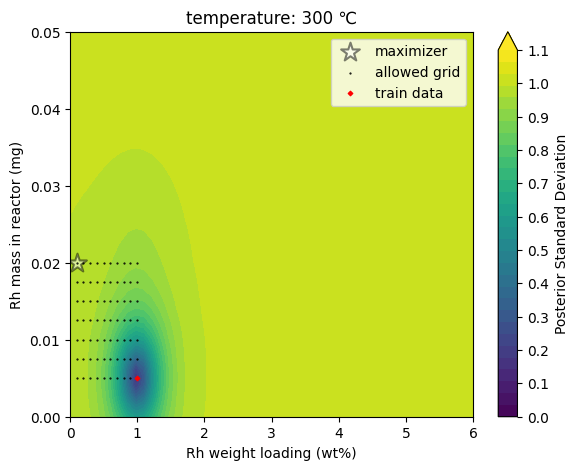

No maximizer found for synthesis method None at temperature 350


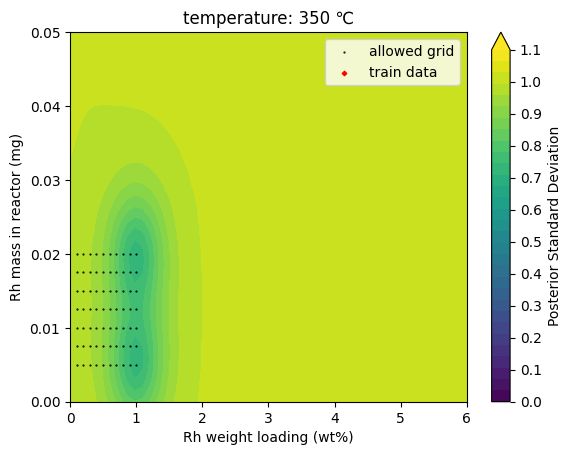

No maximizer found for synthesis method None at temperature 400


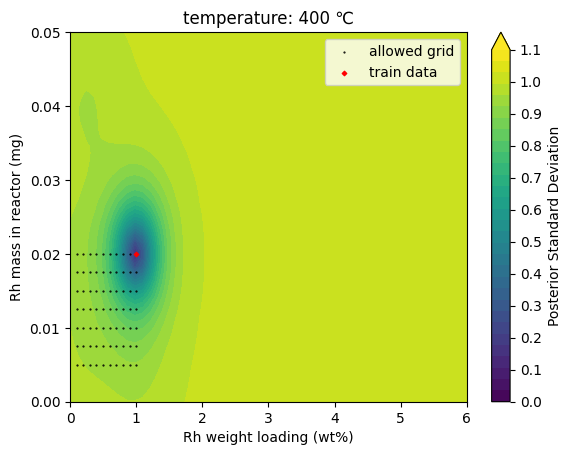

No maximizer found for synthesis method None at temperature 450


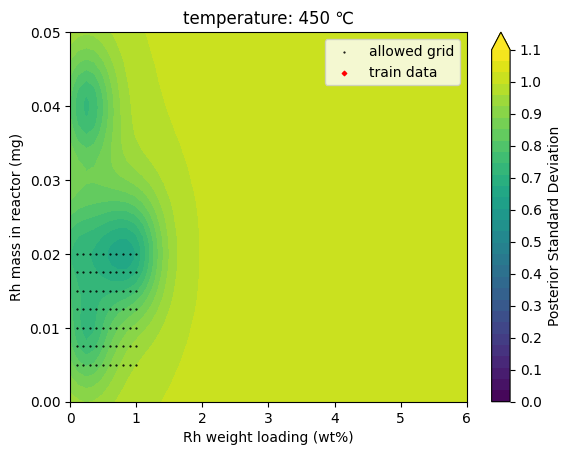

No maximizer found for synthesis method None at temperature 500


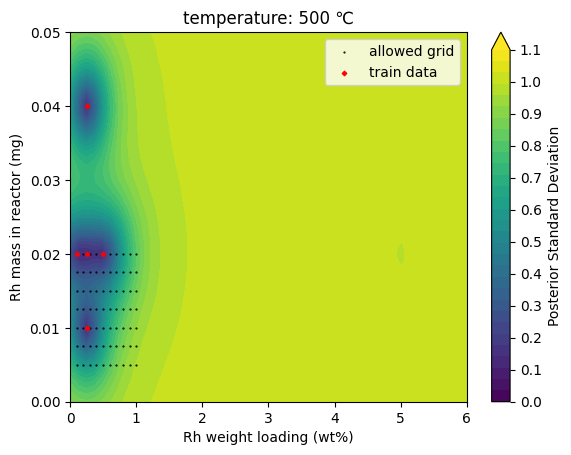

No maximizer found for synthesis method None at temperature 550


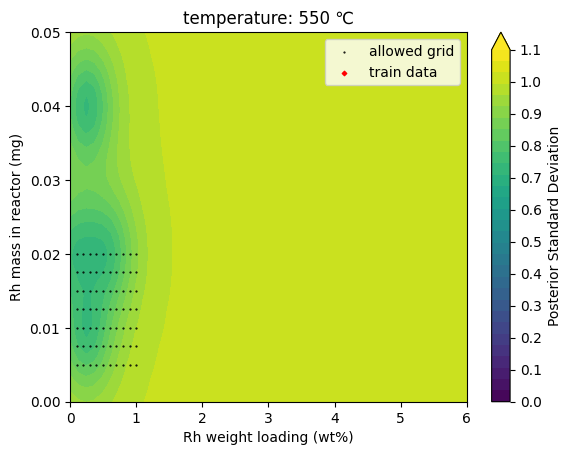

In [4]:
# Plot the acquisition function
Plot = pl.Plotter(GP=GP, Grid=Grid)

Plot.plot_2d_acquisition_function(
    synth_method='NP',
    acq_max=1.1,
    n_levels=32,
    temperature_list=[300, 350, 400, 450, 500, 550],
    mode='custom', #'boundary',
    custom_range=(0.0, 6.0, 0.0, 0.05),  # Custom range for contour plot
    contour_resolution=50,
    plot_allowed_grid=True,
    plot_train=True
)

### b. 3D distribution of the acquisition function for each synthesis method

Maximizer for synthesis method NP: {'reaction_temp': 300.0, 'Rh_weight_loading': 0.1, 'Rh_total_mass': 0.02, 'synth_method': 1.0}


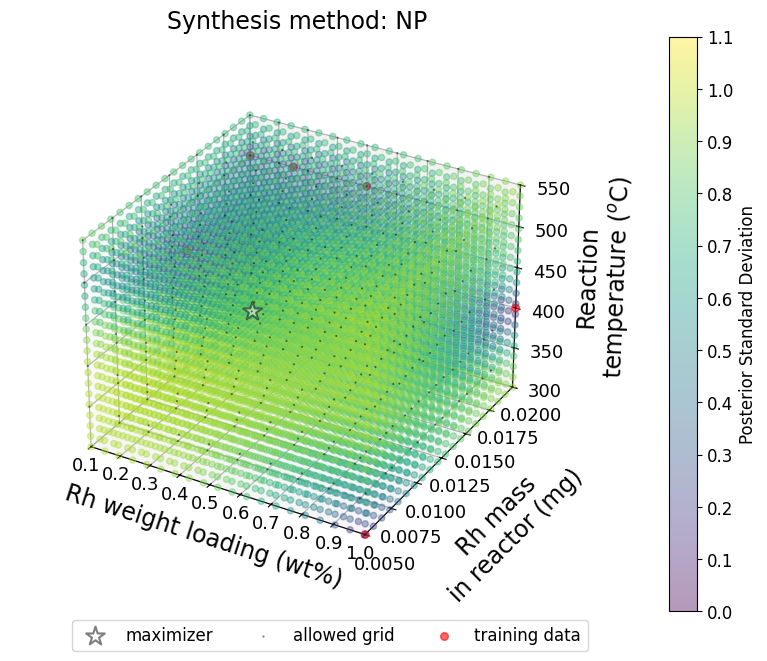

In [5]:
Plot.plot_3d_acquisition_function(
    synth_method='NP',
    acq_max=1.1,
    mode='boundary', #'custom',
    custom_range=(0.0, 6.0, 0.0, 0.05, 300, 550),  # Custom range for contour plot
    contour_resolution=20,
    plot_allowed_grid=True,
    plot_train=True
)

No maximizer found for synthesis method WI


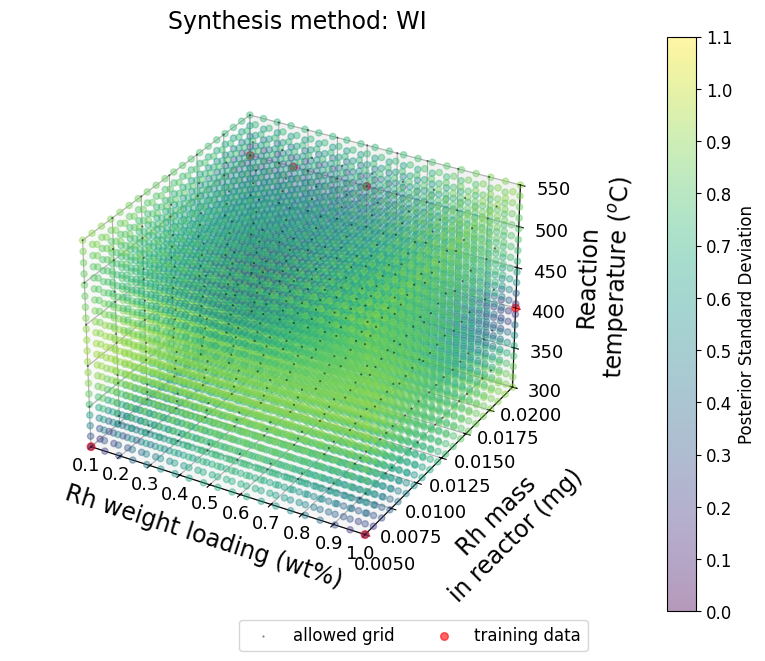

In [6]:
Plot.plot_3d_acquisition_function(
    synth_method='WI',
    acq_max=1.1,
    mode='boundary', #'custom',
    custom_range=(0.0, 6.0, 0.0, 0.05, 300, 550),  # Custom range for contour plot
    contour_resolution=20,
    plot_allowed_grid=True,
    plot_train=True
)